In [ ]:
!wget http://sofacoustics.org/data/database/cipic/subject_009.sofa
!wget http://sofacoustics.org/data/database/cipic/subject_008.sofa
!wget https://gist.githubusercontent.com/yoyololicon/f63f601d62187562070a61377cec9bf8/raw/151851a12c64c0e7b8daaf6a4616556e6e562e37/differentiable_lfilter.py

In [1]:
import torch
import torch.nn.functional as F
import torch.fft as fft
from differentiable_lfilter import lfilter
from math import pi
import numpy as np
from scipy import signal
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import spaudiopy as spa
from torch import optim
from matplotlib import rc

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

%matplotlib inline

/home/ycy/miniconda3/envs/hrtf_notebooks/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


## Define Shelving and Peak Filters

In [2]:

class _LTI(torch.nn.Module):
    lfilter = lfilter.apply

    def get_poly(self) -> (torch.Tensor, torch.Tensor):
        raise NotImplementedError

    def get_log_mag(self, nfft):
        a, b = self.get_poly()

        B = fft.rfft(b, nfft).abs().add(1e-12).log10()
        A = fft.rfft(a, nfft).abs().add(1e-12).log10()
        return (B - A) * 20

    def forward(self, x):
        a, b = self.get_poly()
        y = self.lfilter(x, a, b)
        return y


class _FS(_LTI):
    _fc_logits: torch.nn.Parameter
    fs: torch.Tensor
    G: torch.nn.Parameter

    def __init__(self, fc=22050., fs=44100.):
        super().__init__()
        fc = fc / fs
        fc = math.log(fc / (1 - fc))
        self._fc_logits = torch.nn.Parameter(torch.Tensor([fc]))
        self.register_buffer('fs', torch.Tensor([fs]))

    def fc(self):
        return self._fc_logits.sigmoid() * self.fs

    def V_0(self) -> torch.Tensor:
        return 10 ** (self.G * 0.05)


class LFS(_FS):
    def __init__(self, *args, gain=0., **kwargs):
        super().__init__(*args, **kwargs)
        self.G = torch.nn.Parameter(torch.Tensor([gain]))

    def get_poly(self):
        V_0 = self.V_0()
        H_0 = V_0 - 1
        tmp = torch.tan(self._fc_logits.sigmoid() * pi)
        a = (tmp + F.threshold(-V_0, -1, -1)) / (tmp - F.threshold(-V_0, -1, -1))

        b = torch.cat([1 + 0.5 * H_0 * (1 + a), a + 0.5 * H_0 * (1 + a)])
        a = torch.cat([a.new_ones(1), a])
        return a, b


class HFS(LFS):
    def get_poly(self):
        V_0 = self.V_0()
        H_0 = V_0 - 1
        tmp = torch.tan(self._fc_logits.sigmoid() * pi)
        a = (tmp * (-F.threshold(-V_0, -1, -1)) - 1) / (tmp * (-F.threshold(-V_0, -1, -1)) + 1)

        b = torch.cat([1 + 0.5 * H_0 * (1 - a), a - 0.5 * H_0 * (1 - a)])
        a = torch.cat([a.new_ones(1), a])
        return a, b


class Peak(_LTI):
    _fb_limits = (100, 4000)
    _fb_logits: torch.nn.Parameter
    _fc_logits: torch.nn.Parameter
    fs: torch.Tensor
    G: torch.nn.Parameter

    def __init__(self, gain=0., fb=500., fc=22050., fs=44100.):
        super().__init__()
        fc = fc / fs
        fc = math.log(fc / (1 - fc))
        self._fc_logits = torch.nn.Parameter(torch.Tensor([fc]))
        fb = (fb - self._fb_limits[0]) / (self._fb_limits[1] - self._fb_limits[0])
        fb = math.log(fb / (1 - fb))
        self._fb_logits = torch.nn.Parameter(torch.Tensor([fb]))
        self.register_buffer('fs', torch.Tensor([fs]))
        self.G = torch.nn.Parameter(torch.Tensor([gain]))

    def fb(self):
        return self._fb_logits.sigmoid() * (self._fb_limits[1] - self._fb_limits[0]) + self._fb_limits[0]

    def fc(self):
        return self._fc_logits.sigmoid() * self.fs

    def get_poly(self) -> (torch.Tensor, torch.Tensor):
        V_0 = 10 ** (self.G * 0.05)
        H_0 = V_0 - 1
        tmp = torch.tan(self.fb() / self.fs * pi)
        d = -torch.cos(2 * pi * self.fc() / self.fs)

        a = (tmp + F.threshold(-V_0, -1, -1)) / (tmp - F.threshold(-V_0, -1, -1))

        b = torch.cat([1 + 0.5 * H_0 * (1 + a), d * (1 - a), -a - 0.5 * H_0 * (a + 1)])
        a = torch.cat([a.new_ones(1), d * (1 - a), -a])
        return a, b



## HRTF approximator

In [3]:

class HRTF_IIR(_LTI):
    def __init__(self, N=6, gain=None, fc=None, fb=None, fs=44100.):
        super().__init__()

        if gain is None:
            gain = torch.rand(N) * 20 - 10
            gain = [0.] * N
        if fc is None:
            fc = torch.linspace(400, min(16000, fs * 0.5), N)[1:-1]
        if fb is None:
            fb = [500.] * N

        tmp = [LFS(gain=0., fc=100., fs=fs)]

        for g, c, b in zip(gain, fc, fb):
            tmp.append(Peak(gain=g, fc=c, fb=b, fs=fs))

        tmp += [HFS(gain=-0., fc=16000., fs=fs)]
        self.cascade = torch.nn.Sequential(*tmp)

    def forward(self, x, fast=False):
        if fast:
            return super().forward(x)
        return self.cascade(x)

    @staticmethod
    def coeff_product(c1, c2):
        if c1.shape[0] > c2.shape[0]:
            c1, c2 = c2, c1
        outer = torch.outer(c1, c2)
        eye_kernel = torch.eye(outer.shape[0],
                               dtype=outer.dtype,
                               device=outer.device).flip(1).view(1, 1, outer.shape[0], outer.shape[0])
        return F.conv1d(F.pad(outer, [outer.shape[0] - 1] * 2).view(1, 1, outer.shape[0], -1),
                        eye_kernel).view(-1)

    def get_poly(self) -> (torch.Tensor, torch.Tensor):
        a = b = None
        for i, layer in enumerate(self.cascade.children()):
            a2, b2 = layer.get_poly()
            if not i:
                a, b = a2, b2
                continue
            a = self.coeff_product(a2, a)
            b = self.coeff_product(b2, b)
        return a, b

    def get_log_mag(self, nfft, fast=False):
        if fast:
            return super().get_log_mag(nfft)

        y = None
        for i, layer in enumerate(self.cascade.children()):
            if not i:
                y = layer.get_log_mag(nfft)
                continue
            y += layer.get_log_mag(nfft)
        return y

In [4]:
filename = "subject_008.sofa"
az = 80
ele = 0
nfft = 1024
right_ear = True

sofa_file = spa.IO.load_sofa_data(filename)
sr = float(sofa_file['Data.SamplingRate'])
sph_coords = sofa_file['SourcePosition']
HRIR = sofa_file['Data.IR']

mask = (sph_coords[:, 0] == az) & (sph_coords[:, 1] == ele)
ir = HRIR[mask, 1 if right_ear else 0]
ir = np.squeeze(ir)
print(ir.shape)

(200,)


# Get peaks and approximate bandwidth by slope

[1150.3535836  3000.         1951.40156377 3000.         1072.88946112
 1082.50178064 1722.08520915  674.76124533 1386.33042018  249.02316833
  296.88863575  200.        ]


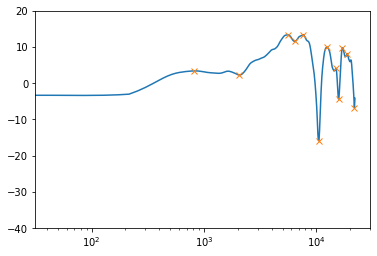

In [5]:
H = 20 * np.log10(np.abs(np.fft.rfft(ir, nfft)))
w = np.ones(11) / 11
smoothed_H = signal.fftconvolve(H, w, 'same')
freqs = np.arange(smoothed_H.shape[0]) / nfft * sr

up_peaks, _ = signal.find_peaks(smoothed_H, prominence=0.6, height=(-20, None),
                                distance=round(300 / sr * nfft))
down_peaks, _ = signal.find_peaks(-smoothed_H, prominence=1, height=(None, 40),
                                  distance=round(300 / sr * nfft))

up_gain = np.maximum(H[up_peaks], 1)
down_gain = np.minimum(H[down_peaks], -1)

peaks = np.concatenate((up_peaks, down_peaks))
gains = np.concatenate((up_gain, down_gain))

step = 4
left_slope = np.take(smoothed_H, peaks[:, None] + np.arange(step)) - \
             np.take(smoothed_H, peaks[:, None] - np.arange(1, step + 1))
left_slope = left_slope.mean(1)
right_slope = np.take(smoothed_H, peaks[:, None] + np.arange(step)) - \
             np.take(smoothed_H, peaks[:, None] + np.arange(1, step + 1))
right_slope = right_slope.mean(1)
slope = 0.5 * (np.abs(left_slope) + np.abs(right_slope))
fb = sr / slope * 0.002
fb = np.clip(fb, 200, 3000)
print(fb)

plt.plot(freqs, smoothed_H)
plt.plot(freqs[peaks], smoothed_H[peaks], "x")
plt.xscale('log')
plt.ylim(-40, 20)
plt.show()

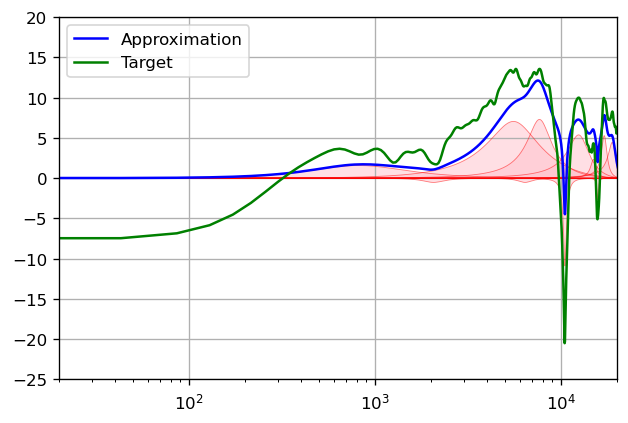

In [10]:
N = len(peaks)
epochs = 1000
model = HRTF_IIR(fs=sr, fc=freqs[peaks], gain=gains / N ** 0.25, fb=fb, N=N)

fig = plt.figure(dpi=120)
cascaded = np.zeros(nfft // 2 + 1)
for i, layer in enumerate(model.cascade.children()):
    m = layer.get_log_mag(nfft).detach().numpy()
    plt.semilogx(freqs, m, 'r-', linewidth=0.5, alpha=0.5)
    plt.fill_between(freqs, m, 0, facecolor='pink', edgecolor='none', alpha=0.5)
    cascaded += m

plt.semilogx(freqs, cascaded, 'b-', label='Approximation')
plt.semilogx(freqs, H, 'g-', label='Target')
plt.legend()
plt.grid()
plt.ylim(-25, 20)
plt.xlim(20, 20000)
plt.show()


## Training

Instead of backpropogating in time domain, I evaluate the system in frequency domain to achieve more stable convergence.

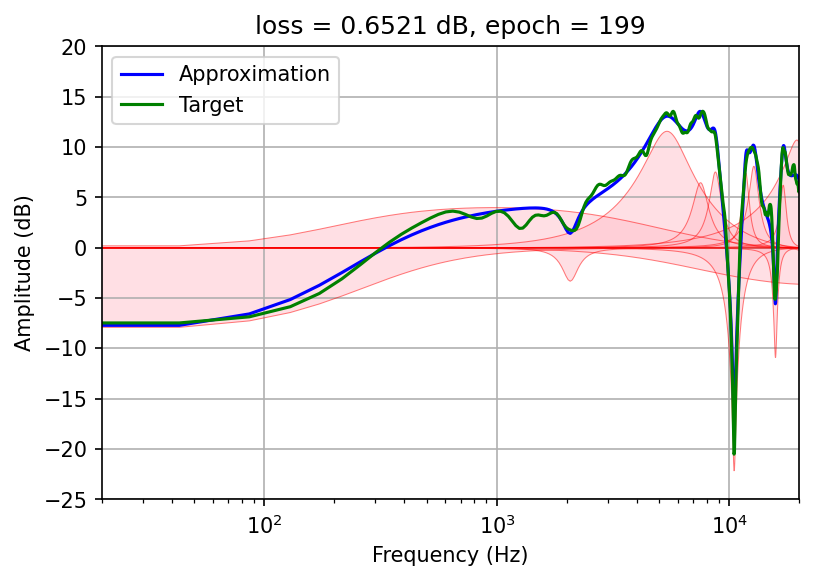

In [11]:
model = model.cuda()
optimizer = optim.Adam(model.parameters(), 0.1)
y = torch.FloatTensor(H).cuda()
epochs = 200

fig = plt.figure(dpi=150)
ax = fig.subplots()

lines = []
cascaded[:] = 0
for i, layer in enumerate(model.cascade.children()):
    m = layer.get_log_mag(nfft).detach().cpu().numpy()
    l, = ax.semilogx(freqs, m, 'r-', linewidth=0.5, alpha=0.5)
    f = ax.fill_between(freqs, m, 0, facecolor='pink', edgecolor='none', alpha=0.5)
    lines.append(l)
    cascaded += m
    
approx, = ax.semilogx(freqs, cascaded, 'b-', label='Approximation')


def init():
    ax.semilogx(freqs, H, 'g-', label='Target')
    ax.set_ylim(-25, 20)
    ax.set_xlim(20, 20000)
    ax.legend(loc='upper left')
    ax.grid()
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Amplitude (dB)")
    return

def update(frame):
    optimizer.zero_grad()
    output = model.get_log_mag(nfft, False)
    loss = F.mse_loss(output, y)
    loss.backward()
    optimizer.step()
    #print(loss.item(), frame)
    
    ax.collections.clear()
    cascaded = np.zeros(nfft // 2 + 1)
    with torch.no_grad():
        ax.set_title("loss = {:.4f} dB, epoch = {:d}".format(loss.item(), frame))
        for i, layer in enumerate(model.cascade.children()):
            m = layer.get_log_mag(nfft).detach().cpu().numpy()
            lines[i].set_ydata(m)
            ax.fill_between(freqs, m, 0, facecolor='pink', edgecolor='none', alpha=0.5)
            cascaded += m
        approx.set_ydata(cascaded)

    return

ani = animation.FuncAnimation(
    fig, update, init_func=init, frames=epochs, interval=1000 / 24)

ani